In [258]:
import pandas as pd
import sklearn
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = None


from sklearn.linear_model import ElasticNet

In [2]:
import dcor
def disCorrelation(df):
  '''
  Calculates Disco correlation matrix, starting from a df with only numerical attributes
  Returns a dataframe with the correlation coefficients
  '''
  discorr = np.ones((len(df.columns),len(df.columns)))
  print(discorr.shape)
  for iX,(labelX,X) in enumerate(df.items()):
    for iY,(labelY,Y) in enumerate(df.items()):
      discorr[iX,iY] = dcor.distance_correlation(X.to_numpy(),Y.to_numpy())
      
  df_discorr = pd.DataFrame(data=discorr,    # values
                            index=df.columns,
                            columns=df.columns,
                           ) 
  return df_discorr
  #return discorr

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Imports

In [239]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from copy import deepcopy
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder 
import xgboost
from sklearn.model_selection import GridSearchCV

# Pre-processing functions

## Auxiliary functions

In [4]:
def splitTestTrain(df):
  '''
  Split the dataframe into train set and test set, based on year_factor
  '''
  df_test = df[df['year_factor']==7].copy()
  df_train = df[df['year_factor']<7].copy()
  return df_train,df_test


In [404]:
def plot_feature_importances(f_imps, f_names, title="", threshold=None):
  #print(f_imps,type(f_imps)) 
  
  df = pd.DataFrame(data={'name':f_names, 'importance':f_imps})
    
  if threshold:
    df_highest = df[df['importance']>threshold].sort_values('importance', ascending=False)
  
  #f_imps_selected = a[a<2] 
  #f_imps = np.array(f_imps)
  #f_names = np.array(f_names)
  #sort_inds = np.argsort(f_imps)
  yy = np.arange(len(df_highest)).astype(np.int)
  
  
  plt.barh(yy, df_highest['importance'])
  plt.yticks(yy, df_highest['name'], size=11)
  plt.xticks(size=11)
  plt.xlabel("Feature importance", size=14)
  plt.title(title, size=14)
  plt.show()

## Data Reading

In [5]:
def dataRead(f_train='train.csv', f_test='test.csv'):
  '''
  Read the data into pandas DataFrames
  '''
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  return df_train, df_test

## Data Pre-processing

In [6]:
def dataPreprocess(df_train,df_test):
  '''
  Preprocess the data:
    - remove outliers 
    - fill missing values
    - drop duplicates
    - encode text into categories
    - discretise continuous variables if needed 

  Note a different treatment between training and test set.
  '''
  print('\nPreprocessing the data...\n')
  
  df = pd.concat([df_train,df_test])
  
  # first replace all possible infinities with nans, so that the imputation operates on those as well
  df.replace([-np.inf,np.inf], np.nan)
  
  # rename columns so that we have everything with the same case
  df = df.rename(columns={'Year_Factor':'year_factor', 'State_Factor':'state_factor', 'ELEVATION': 'elevation'})
    
  # state_factor obj => to int 
  df.insert(loc=2, column='state_id', value=df['state_factor'].str.split('_').str.get(1).astype(int))

  # building_class obj => to int
  df.insert(loc=4, column='is_residential',  value=(df['building_class'] == 'Residential'))
  df['is_residential'] = df['is_residential'].astype(int)
  
  # elevation categorisation => to int 
  elevation_bins = [-np.inf,40,100,150,250,400,1000,np.inf]
  df.insert(loc=10, column='elevation_cat', value=pd.cut(x=df['elevation'], bins=elevation_bins, labels=False))
  
  # facility type super categorisation
  df.insert(loc=6, column='facility_type_super', value=df['facility_type'].str.split('_').str.get(0))
    
  # year_built imputation 
  print('\nYear built imputation')
  #print ('Before 0 substitution, number of NaNs: {}'.format(df_exp.year_built.isna().sum()))
  df['year_built'].replace(0,np.nan)
  n_nans = df.year_built.isna().sum()
  print ('Before imputation, number of NaNs: {}'.format(n_nans))
  imputation_list = ['state_id','floor_area', 'building_class', 'facility_type']
  for istart,feat in enumerate(imputation_list):
    if n_nans > 0:
      print(imputation_list[istart:])
      df['year_imputed'] = df.groupby(imputation_list[istart:])['year_built'].transform('median')
      df['year_built'] = df['year_built'].fillna(df['year_imputed'] )
      n_nans = df.year_built.isna().sum()
      print ('After imputation step {}, number of NaNs: {}'.format(istart+1, n_nans))
  
  # year_built categorisation => to int
  year_built_bins = [-np.inf,1850,1899,1919,1933,1945,1955,1965,1975,1985,1995,2005,np.inf]
  df.insert(loc=8, column='year_built_cat', value=pd.cut(df['year_built'], bins=year_built_bins, labels=False))

  # energy_star_rating imputation
  print('\nEnergy star rating imputation')
  n_nans = df.energy_star_rating.isna().sum()
  print ('Before imputation, number of NaNs: {}'.format(n_nans))
  imputation_list = ['state_id', 'floor_area', 'building_class', 'facility_type', 'year_built_cat']
  for istart,feat in enumerate(imputation_list):
    if n_nans > 0:
      print(imputation_list[istart:])
      df['energy_star_rating_imputed'] = df.groupby(imputation_list[istart:])['energy_star_rating'].transform('median')
      df['energy_star_rating'] = df['energy_star_rating'].fillna(df['energy_star_rating_imputed'])
      n_nans = df.energy_star_rating.isna().sum()
      print ('After imputation step {}, number of NaNs: {}'.format(istart+1, n_nans))
      
  # avg temperature categorisation => to int
  avg_temp_bins = [-np.inf,52,55,57,58,65,np.inf]
  df.insert(loc=55, column='avg_temp_cat', value=pd.cut(df['avg_temp'], bins=avg_temp_bins, labels=False))
  
  # days_with_fog imputation
  # it makes sense to impute it based on year_factor, elevation_cat, temperature ranges in the avg_temp, 
  print('\nDays_with_fog imputation')
  n_nans = df.days_with_fog.isna().sum()
  print ('Before imputation, number of NaNs: {}'.format(n_nans))
  imputation_list = ['year_factor','elevation_cat', 'avg_temp_cat']
  for istart,feat in enumerate(imputation_list):
    if n_nans > 0:
      print(imputation_list[istart:])
      df['days_with_fog_imputed'] = df.groupby(imputation_list[istart:])['days_with_fog'].transform('median')
      df['days_with_fog'] = df['days_with_fog'].fillna(df['days_with_fog_imputed'] )
      n_nans = df.days_with_fog.isna().sum()
      print ('After imputation step {}, number of NaNs: {}'.format(istart+1, n_nans))
  
  # we separate training and test set because we have a treatment only for the training set
  df_train = df.loc[df.year_factor<7].copy()
  df_test = df.loc[df.year_factor==7].copy()
  
  # drop "duplicates" from the training set
  #   we define duplicates all those entries that have equal year_factor, year_built, state_factor, building_type
  #     This is needed if we want to be able to create a previous history of buildings 
  #     It comes with the assumption that the elevation is not to be trusted 
  #     for distinguishing a building from another
  subset_for_duplicates = ['year_factor', 'building_class', 'facility_type', 'floor_area', 'year_built']
  df_train = df_train.drop_duplicates(subset=subset_for_duplicates, keep='first')
  # we have to remove one example by hand (imputed year slightly different, but same temperatures, etc)
  df_train = df_train.drop(index=35748) 
  
  df = pd.concat([df_train,df_test]).reset_index(drop=True)   

  # building id determination
  df.insert(loc=1, column='building_id', 
            value=df['state_id'].astype('str') + '_' + df['year_built'].astype('int').astype('str') + '_' \
                 +df['facility_type'].astype('str') + '_' + df['floor_area'].astype('int').astype('str')# \
                 #+ '_' + df['elevation'].astype('str')
           )
  df['building_count'] = df.groupby('building_id')['year_factor'].transform('count')
  
  # determine whether given row has a previous history (same building_id, preceding year)
  ## sort df by year_factor (to make sure that year_factor order is maintained when grouping)
  df = df.sort_values(by='year_factor')
  
  ## calculate year diff (with preceding row) inside the building_id grouping
  df['year_factor_diff_1'] = df.groupby('building_id')['year_factor'].diff(1)
  df['year_factor_diff_2'] = df.groupby('building_id')['year_factor'].diff(2)
  
  df_train = df.loc[df.year_factor<7].copy()
  df_test = df.loc[df.year_factor==7].copy()  
  
  # for training set, where building_id is unique and sorted by year_factor 
  df_train.insert(loc=2, column='has_previous_history',
                  value=(df['year_factor_diff_1']>0).astype('int'))
  
  df_test.insert(loc=2, column='has_previous_history',
                  value=( (df['year_factor_diff_1']>0) | (df['year_factor_diff_2']>0) ).astype('int'))
  
  df = pd.concat([df_train,df_test]).reset_index(drop=True)   

  df.insert(loc=3, column='building_id_sameyear_factor_count', 
            value=df.groupby(['building_id','year_factor'])['id'].transform('count'))

  print('\nPreprocessing of data ended...\n')
  
  return df

## Feature Encoding

In [83]:
def featureEncode(df):
  '''
  Perform one-hot encoding / ordinal encoding of categorical features (which were already transformed to int)
  Encoded features are added to the original dataframe with name 'enc_featname_i' 
  '''
  
  features_onehot = [
    'state_id',
    'facility_type',
    'facility_type_super',
  ]
  
  for feat in features_onehot:
    encoder = OneHotEncoder(sparse=False)
    X = encoder.fit_transform(df[feat].to_numpy().reshape(-1,1))
    for i in range(0,X.shape[1]):
      encoded_col = 'enc_{f}_{i}'.format(f=feat,i=i)
      df[encoded_col] = X[:,i]  
  
  return df

## Feature Engineering with History

In [8]:
def featureEngineerHistory(df):
  '''
  - Add promising single transformations
  - Aggreagate features into promising new features
  '''
  
  print('\nFeature Engineering for events with previous history...\n')

  
  df['cooling_heating_degree_days'] = df['cooling_degree_days'] + df['heating_degree_days']
  
  # time lags and diffs:
  # - energy_star_rating: lag and diff, by 1 and 2 periods
  # - site_eui:           lag, by 1 and 2 periods (maybe more?)
  # - weather features:   diff, by 1 and 2 periods 
  
  
  fna = -200
  lags = [1,2]
  weather_features = ['january_avg_temp',  'january_min_temp',  'january_max_temp',  'february_avg_temp',  
                      #'february_min_temp',  'february_max_temp',  'march_avg_temp',  'march_min_temp',  
                      #'march_max_temp',  'april_avg_temp',  'april_min_temp',  'april_max_temp',  
                      #'may_avg_temp',  'may_min_temp',  'may_max_temp',  'june_avg_temp',  
                      #'june_min_temp',  'june_max_temp',  'july_avg_temp',  'july_min_temp',  
                      #'july_max_temp',  'august_avg_temp',  'august_min_temp',  'august_max_temp',  
                      #'september_avg_temp',  'september_min_temp',  'september_max_temp',  'october_avg_temp',  
                      #'october_min_temp',  'october_max_temp',  'november_avg_temp',  'november_min_temp',  
                      #'november_max_temp',  'december_avg_temp',  'december_min_temp',  'december_max_temp',
                      #
                      'avg_temp',
                      #
                      #'days_below_30F','days_below_20F','days_below_10F','days_below_0F',
                      #'days_above_80F','days_above_90F','days_above_100F','days_above_110F', 
                      #
                      'cooling_degree_days','heating_degree_days', 'cooling_heating_degree_days', 
                      #
                      #'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
                      #
                      #'days_with_fog',
                     ]
  
  for lag in lags:
    print('\nLag {}'.format(lag))
    df['energy_star_rating_lag_{}'.format(lag)] = df.groupby('building_id')['energy_star_rating'].shift(lag).fillna(fna)
    df['energy_star_rating_diff_{}'.format(lag)] = df.groupby('building_id')['energy_star_rating'].diff(lag).fillna(fna)
  
    df['site_eui_lag_{}'.format(lag)] = df.groupby('building_id')['site_eui'].shift(lag).fillna(fna)
    
    for feat in weather_features:
      df['{}_lag_{}'.format(feat,lag)] = df.groupby('building_id')[feat].shift(lag).fillna(fna)
      df['{}_diff_{}'.format(feat,lag)] = df.groupby('building_id')[feat].diff(lag).fillna(fna)
  
  
  print('\nFeature Engineering ended...\n')

  
  return df

## Feature Engineering (no History)

In [106]:
def featureEngineer(df):
  '''
  - Add promising single transformations
  - Aggreagate features into promising new features
  '''
  
  print('\nFeature Engineering for events without previous history...\n')

  
  df['cooling_heating_degree_days'] = df['cooling_degree_days'] + df['heating_degree_days']
  
  # seasonal characteristics (calculate avg, min, max from available information)
  seasons = ['winter', 'spring', 'summer', 'fall']
  months = {
    'winter': ['january', 'february', 'march'],
    'spring': ['april', 'may', 'june'],
    'summer': ['july','august','september',],
    'fall'  : ['october','november','december',]
  }
  
  aggs = ['avg', 'min', 'max']
  
  for season in seasons:
    for agg in aggs:
      l = ['{}_{}_temp'.format(month,agg) for month in months[season]]
      df['{}_{}_temp'.format(season,agg)] = df[l].mean(axis=1)
      #print(df['{}_{}_temp'.format(season,agg)])

  print('\nFeature Engineering ended...\n')

  
  return df

## Feature Scaling with History

In [9]:
def featureScaleHistory(df):
  '''
  Apply feature scaling (minmax or standardisation)
  '''
  
  features_minmax = [
    'site_eui_lag_1', 
    'site_eui_lag_2', 
    'energy_star_rating', 
    'energy_star_rating_lag_2',
    'energy_star_rating_lag_1', 
    'january_min_temp', 
    'january_avg_temp', 
    'january_min_temp_lag_1',
    
  ]
  
  features_std = ['cooling_heating_degree_days']

  for feat in features_minmax:
    scaler = MinMaxScaler()
    feat_scaled = scaler.fit_transform(df[feat].to_numpy().reshape(-1, 1))
    df['scaled_'+feat] = feat_scaled.reshape(-1)
    
  for feat in features_std:
    scaler = StandardScaler()
    feat_scaled = scaler.fit_transform(df[feat].to_numpy().reshape(-1, 1))
    df['scaled_'+feat] = feat_scaled.reshape(-1)

  return df

## Feature Scaling (no History)

In [134]:
def featureScale(df):
  '''
  Apply feature scaling (minmax or standardisation)
  '''
  
  features_minmax = [ 
    'year_built',
    'energy_star_rating', 
    
    'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
    
    'winter_min_temp', 'winter_max_temp', 'spring_avg_temp',
    'spring_min_temp', 'spring_max_temp', 'summer_avg_temp',
    'summer_min_temp', 'summer_max_temp', 'fall_avg_temp',
    'fall_min_temp', 'fall_max_temp', 
    
    'avg_temp',
    
    'days_below_30F','days_below_20F','days_below_10F','days_below_0F','days_above_80F','days_above_90F','days_above_100F','days_above_110F',
    
    'precipitation_inches',
    'days_with_fog',
    'direction_max_wind_speed',
    'direction_peak_wind_speed',
    'max_wind_speed',

  ]
  
  features_std = [
    'cooling_heating_degree_days',
    'cooling_degree_days',
    'heating_degree_days',
    'elevation',
    'floor_area',
    'snowdepth_inches',
    'snowfall_inches',

  ]

  for feat in features_minmax:
    scaler = MinMaxScaler()
    feat_scaled = scaler.fit_transform(df[feat].to_numpy().reshape(-1, 1))
    df['scaled_'+feat] = feat_scaled.reshape(-1)
    
  for feat in features_std:
    scaler = StandardScaler()
    feat_scaled = scaler.fit_transform(df[feat].to_numpy().reshape(-1, 1))
    df['scaled_'+feat] = feat_scaled.reshape(-1)

  return df

## Feature Selection with History

In [141]:
def featureSelectHistory(df):
  '''
  Keep only a subset of the features
  '''
  
  ## keep only 
  features_to_use = [ 
       'site_eui',
       'year_factor',
       'has_previous_history',
       'scaled_site_eui_lag_1',
       'scaled_site_eui_lag_2', 
       'scaled_energy_star_rating',
       'scaled_energy_star_rating_lag_1',
       'scaled_energy_star_rating_lag_2', 
       'scaled_january_min_temp', 
       'scaled_january_avg_temp',
       'scaled_january_min_temp_lag_1', 
       'scaled_cooling_heating_degree_days',
      ]

  return df[features_to_use].copy() 

  # I return a copy, because I would get warnings and potentially unpredictable behaviour 
  # if I then apply further slicing/indexing to an already sliced dataset
  
  
  # building_class
  # state_factor
  
  # 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed',
  
  # year_imputed, energy_star_rating_imputed, days_with_fog_imputed, building_count
  
  return df

## Feature Selection (no History)

In [163]:
def featureSelect(df):
  '''
  Keep only a subset of the features
  '''
  
  features_to_use = [
    'site_eui', 
    
    #'id',
    'year_factor', 
    #'building_id', 
    'has_previous_history',
    #'building_id_sameyear_factor_count', 
    
    'is_residential', 
    'year_built_cat',
    'scaled_year_built',
    'scaled_energy_star_rating', 
    'elevation_cat',
    'scaled_elevation', 
    'scaled_floor_area', 

    # state id encoding
    'enc_state_id_0', 'enc_state_id_1',
    'enc_state_id_2', 'enc_state_id_3', 'enc_state_id_4',
    'enc_state_id_5', 'enc_state_id_6', 'enc_facility_type_0',
    
    # facility type encoding
    'enc_facility_type_1', 'enc_facility_type_2',
    'enc_facility_type_3', 'enc_facility_type_4',
    'enc_facility_type_5', 'enc_facility_type_6',
    'enc_facility_type_7', 'enc_facility_type_8',
    'enc_facility_type_9', 'enc_facility_type_10',
    'enc_facility_type_11', 'enc_facility_type_12',
    'enc_facility_type_13', 'enc_facility_type_14',
    'enc_facility_type_15', 'enc_facility_type_16',
    'enc_facility_type_17', 'enc_facility_type_18',
    'enc_facility_type_19', 'enc_facility_type_20',
    'enc_facility_type_21', 'enc_facility_type_22',
    'enc_facility_type_23', 'enc_facility_type_24',
    'enc_facility_type_25', 'enc_facility_type_26',
    'enc_facility_type_27', 'enc_facility_type_28',
    'enc_facility_type_29', 'enc_facility_type_30',
    'enc_facility_type_31', 'enc_facility_type_32',
    'enc_facility_type_33', 'enc_facility_type_34',
    'enc_facility_type_35', 'enc_facility_type_36',
    'enc_facility_type_37', 'enc_facility_type_38',
    'enc_facility_type_39', 'enc_facility_type_40',
    'enc_facility_type_41', 'enc_facility_type_42',
    'enc_facility_type_43', 'enc_facility_type_44',
    'enc_facility_type_45', 'enc_facility_type_46',
    'enc_facility_type_47', 'enc_facility_type_48',
    'enc_facility_type_49', 'enc_facility_type_50',
    'enc_facility_type_51', 'enc_facility_type_52',
    'enc_facility_type_53', 'enc_facility_type_54',
    'enc_facility_type_55', 'enc_facility_type_56',
    'enc_facility_type_57', 'enc_facility_type_58',
    'enc_facility_type_59', 'enc_facility_type_super_0',
    'enc_facility_type_super_1', 'enc_facility_type_super_2',
    'enc_facility_type_super_3', 'enc_facility_type_super_4',
    'enc_facility_type_super_5', 'enc_facility_type_super_6',
    'enc_facility_type_super_7', 'enc_facility_type_super_8',
    'enc_facility_type_super_9', 'enc_facility_type_super_10',
    'enc_facility_type_super_11', 'enc_facility_type_super_12',
    'enc_facility_type_super_13', 'enc_facility_type_super_14',
    'enc_facility_type_super_15', 'enc_facility_type_super_16',
    'enc_facility_type_super_17', 'enc_facility_type_super_18',
    'enc_facility_type_super_19', 'enc_facility_type_super_20',    
      
    'scaled_january_min_temp',
    'scaled_january_avg_temp', 'scaled_january_max_temp',
    'scaled_february_min_temp', 'scaled_february_avg_temp',
    'scaled_february_max_temp', 'scaled_march_min_temp',
    'scaled_march_avg_temp', 'scaled_march_max_temp',
    'scaled_april_min_temp', 'scaled_april_avg_temp',
    'scaled_april_max_temp', 'scaled_may_min_temp',
    'scaled_may_avg_temp', 'scaled_may_max_temp',
    'scaled_june_min_temp', 'scaled_june_avg_temp',
    'scaled_june_max_temp', 'scaled_july_min_temp',
    'scaled_july_avg_temp', 'scaled_july_max_temp',
    'scaled_august_min_temp', 'scaled_august_avg_temp',
    'scaled_august_max_temp', 'scaled_september_min_temp',
    'scaled_september_avg_temp', 'scaled_september_max_temp',
    'scaled_october_min_temp', 'scaled_october_avg_temp',
    'scaled_october_max_temp', 'scaled_november_min_temp',
    'scaled_november_avg_temp', 'scaled_november_max_temp',
    'scaled_december_min_temp', 'scaled_december_avg_temp',
    'scaled_december_max_temp', 'scaled_cooling_degree_days',
    'scaled_avg_temp', 
    
    'scaled_days_with_fog', 
    'scaled_direction_max_wind_speed',
    'scaled_direction_peak_wind_speed', 
    'scaled_max_wind_speed',
    
    'scaled_cooling_heating_degree_days',
    'scaled_cooling_degree_days', 
    'scaled_heating_degree_days',
      
    'scaled_days_below_30F', 'scaled_days_below_20F',
    'scaled_days_below_10F', 'scaled_days_below_0F',
    'scaled_days_above_80F', 'scaled_days_above_90F',
    'scaled_days_above_100F', 'scaled_days_above_110F',    
   
    'scaled_snowdepth_inches',
    'scaled_snowfall_inches', 
    'scaled_precipitation_inches',
      
    'scaled_winter_min_temp',
    'scaled_winter_max_temp', 'scaled_spring_avg_temp',
    'scaled_spring_min_temp', 'scaled_spring_max_temp',
    'scaled_summer_avg_temp', 'scaled_summer_min_temp',
    'scaled_summer_max_temp', 'scaled_fall_avg_temp',
    'scaled_fall_min_temp', 'scaled_fall_max_temp',
      
  ]

  return df[features_to_use].copy() 

  # I return a copy, because I would get warnings and potentially unpredictable behaviour 
  # if I then apply further slicing/indexing to an already sliced dataset
  
  return df

# Main

## Pre-processing

In [371]:
df_train,df_test = dataRead()
len(df_train),len(df_test)

(75757, 9705)

In [372]:
df = pd.concat([df_train,df_test])
df.shape

(85462, 64)

In [373]:
df = dataPreprocess(df_train,df_test)
df_preprocessed = df.copy() # keep it away for test set
df.shape


Preprocessing the data...


Year built imputation
Before imputation, number of NaNs: 1929
['state_id', 'floor_area', 'building_class', 'facility_type']
After imputation step 1, number of NaNs: 1771
['floor_area', 'building_class', 'facility_type']
After imputation step 2, number of NaNs: 1739
['building_class', 'facility_type']
After imputation step 3, number of NaNs: 0

Energy star rating imputation
Before imputation, number of NaNs: 28963
['state_id', 'floor_area', 'building_class', 'facility_type', 'year_built_cat']
After imputation step 1, number of NaNs: 14792
['floor_area', 'building_class', 'facility_type', 'year_built_cat']
After imputation step 2, number of NaNs: 14679
['building_class', 'facility_type', 'year_built_cat']
After imputation step 3, number of NaNs: 3263
['facility_type', 'year_built_cat']
After imputation step 4, number of NaNs: 3263
['year_built_cat']
After imputation step 5, number of NaNs: 0

Days_with_fog imputation
Before imputation, number of NaNs: 54913
[

(84188, 79)

In [374]:
df.columns

Index(['year_factor', 'building_id', 'has_previous_history',
       'building_id_sameyear_factor_count', 'state_factor', 'state_id',
       'building_class', 'is_residential', 'facility_type',
       'facility_type_super', 'floor_area', 'year_built_cat', 'year_built',
       'energy_star_rating', 'elevation', 'elevation_cat', 'january_min_temp',
       'january_avg_temp', 'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
   

## Events with History

### Engineer, scale, select

In [355]:
df = featureEngineerHistory(df)
df.shape,df.columns


Feature Engineering for events with previous history...


Lag 1

Lag 2

Feature Engineering ended...



((84188, 118),
 Index(['year_factor', 'building_id', 'has_previous_history',
        'building_id_sameyear_factor_count', 'state_factor', 'state_id',
        'building_class', 'is_residential', 'facility_type',
        'facility_type_super',
        ...
        'february_avg_temp_lag_2', 'february_avg_temp_diff_2', 'avg_temp_lag_2',
        'avg_temp_diff_2', 'cooling_degree_days_lag_2',
        'cooling_degree_days_diff_2', 'heating_degree_days_lag_2',
        'heating_degree_days_diff_2', 'cooling_heating_degree_days_lag_2',
        'cooling_heating_degree_days_diff_2'],
       dtype='object', length=118))

In [356]:
df = featureScaleHistory(df)
df.shape,df.columns

((84188, 127),
 Index(['year_factor', 'building_id', 'has_previous_history',
        'building_id_sameyear_factor_count', 'state_factor', 'state_id',
        'building_class', 'is_residential', 'facility_type',
        'facility_type_super',
        ...
        'cooling_heating_degree_days_diff_2', 'scaled_site_eui_lag_1',
        'scaled_site_eui_lag_2', 'scaled_energy_star_rating',
        'scaled_energy_star_rating_lag_2', 'scaled_energy_star_rating_lag_1',
        'scaled_january_min_temp', 'scaled_january_avg_temp',
        'scaled_january_min_temp_lag_1', 'scaled_cooling_heating_degree_days'],
       dtype='object', length=127))

In [357]:
df = featureSelectHistory(df)
df.shape,df.columns

((84188, 12),
 Index(['site_eui', 'year_factor', 'has_previous_history',
        'scaled_site_eui_lag_1', 'scaled_site_eui_lag_2',
        'scaled_energy_star_rating', 'scaled_energy_star_rating_lag_1',
        'scaled_energy_star_rating_lag_2', 'scaled_january_min_temp',
        'scaled_january_avg_temp', 'scaled_january_min_temp_lag_1',
        'scaled_cooling_heating_degree_days'],
       dtype='object'))

### Linear model
We consider for now only rows **with previous history**, with a **small number of features**. In this simplified case, we have strong linear correlation with the site_eui of the previous year. We try to build a linear model

#### Preliminary

In [358]:
df_h = df.loc[df['has_previous_history']==1].copy()
df_h = df_h.drop(columns=['has_previous_history'])
df.shape,df_h.shape

((84188, 12), (57603, 11))

In [359]:
df_train,df_test = splitTestTrain(df_h)
df_train.shape,df_test.shape

((48555, 11), (9048, 11))

In [360]:
abs(df_train.corr())['site_eui'].sort_values(ascending=False)

site_eui                              1.000000
scaled_site_eui_lag_1                 0.912507
scaled_energy_star_rating             0.426835
scaled_energy_star_rating_lag_1       0.392748
scaled_site_eui_lag_2                 0.190093
scaled_january_min_temp               0.176666
scaled_cooling_heating_degree_days    0.166191
scaled_january_avg_temp               0.162738
scaled_january_min_temp_lag_1         0.159416
year_factor                           0.053875
scaled_energy_star_rating_lag_2       0.019217
Name: site_eui, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febb1e85ee0>,
      dtype=object)

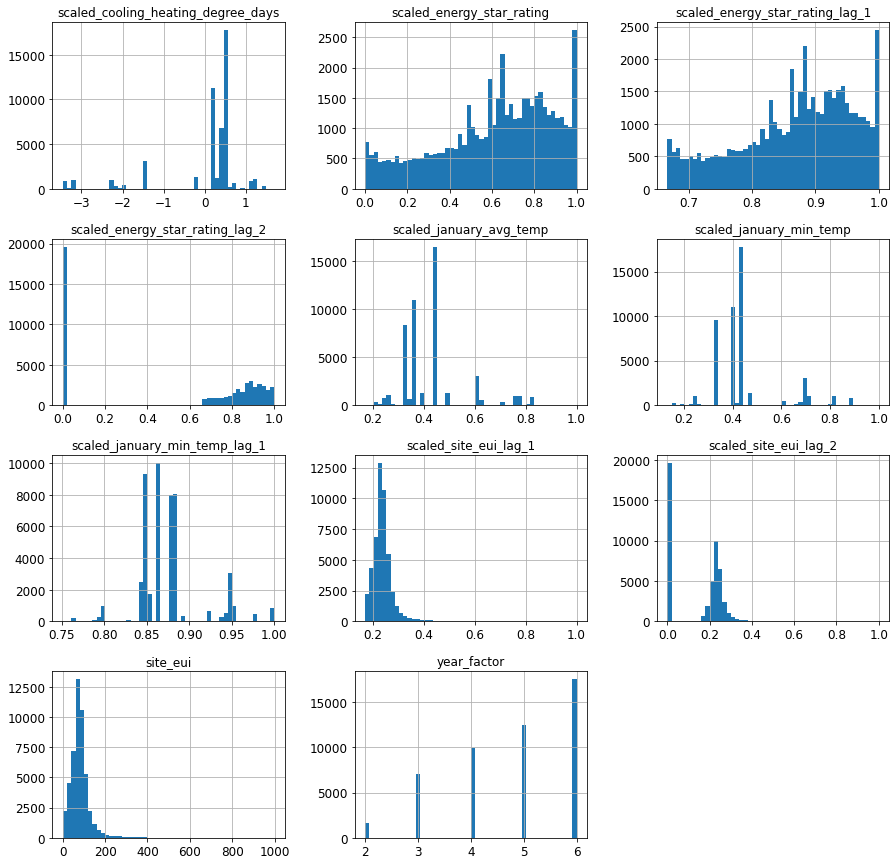

In [361]:
df_train.hist(figsize=(15,15), bins=50)

In [362]:
#sns.jointplot(x='scaled_site_eui_lag_1', y='site_eui', data=df_train, kind='reg')
df_train.columns

Index(['site_eui', 'year_factor', 'scaled_site_eui_lag_1',
       'scaled_site_eui_lag_2', 'scaled_energy_star_rating',
       'scaled_energy_star_rating_lag_1', 'scaled_energy_star_rating_lag_2',
       'scaled_january_min_temp', 'scaled_january_avg_temp',
       'scaled_january_min_temp_lag_1', 'scaled_cooling_heating_degree_days'],
      dtype='object')

In [363]:
X_train = df_train.iloc[:,2:].values
y_train = df_train.iloc[:,0:1].values

X_test = df_test.iloc[:,2:].values
#y_test  to be predicted

print(X_train.shape,X_test.shape,y_train.shape)

(48555, 9) (9048, 9) (48555, 1)


In [364]:
#plt.scatter(X_train, y_train)

In [365]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.3, random_state=10, shuffle=True)
X_t.shape,X_v.shape,y_t.shape,y_v.shape

((33988, 9), (14567, 9), (33988, 1), (14567, 1))

In [35]:
#sgd_reg = SGDRegressor(max_iter=5000, tol=1e-3, penalty='elasticnet', learning_rate='adaptive', eta0=0.01, random_state=42,
#                       n_iter_no_change=10)
#
#sgd_scores = cross_val_score(sgd_reg,X_train,y_train.ravel(),cv=5,scoring='neg_mean_squared_error')
#
#np.sqrt(-sgd_scores).mean(), np.sqrt(-sgd_scores).std()

#### Epoch training, best model

In [1]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty='elasticnet', learning_rate="adaptive", eta0=0.01, random_state=42, n_iter_no_change=10)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_t, y_t.ravel())  # continues where it left off
  y_v_predict = sgd_reg.predict(X_v)
  val_error = mean_squared_error(y_v.ravel(), y_v_predict)
  #print(val_error)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = deepcopy(sgd_reg)

best_model.coef_

NameError: name 'SGDRegressor' is not defined

In [367]:
best_model

SGDRegressor(learning_rate='adaptive', max_iter=1, n_iter_no_change=10,
             penalty='elasticnet', random_state=42, tol=-inf, warm_start=True)

#### Epoch training, plot

Best RMSE train =22.775803
Best RMSE val   =22.798442
Pct change = 0.10%


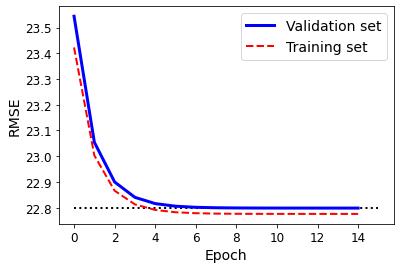

In [368]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty='elasticnet', learning_rate="adaptive", eta0=0.1, random_state=42, 
                       alpha=0.00005,l1_ratio=0.01,
                     #  alpha=0.00005,l1_ratio=0.001
                      )

n_epochs = 15
train_errors, val_errors = [], []
for epoch in range(n_epochs):
  sgd_reg.fit(X_t, y_t.ravel())
  y_t_predict = sgd_reg.predict(X_t)
  y_v_predict = sgd_reg.predict(X_v)
  train_errors.append(mean_squared_error(y_t.ravel(), y_t_predict))
  val_errors.append(mean_squared_error(y_v.ravel(), y_v_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])
best_train_rmse = np.sqrt(train_errors[best_epoch])

##plt.annotate('Best model',
#             xy=(best_epoch, best_val_rmse),
#             xytext=(best_epoch, best_val_rmse + 1),
#             ha="center",
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#            )
print('Best RMSE train ={:2f}'.format(best_train_rmse))
print('Best RMSE val   ={:2f}'.format(best_val_rmse))
print('Pct change = {:.2f}%'.format((best_val_rmse/best_train_rmse-1)*100))


#best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

#### Predictions on the test set

In [369]:
y_predict_test_history = best_model.predict(X_test)
y_predict_test_history.shape

(9048,)

In [370]:
y_predict_test_history

array([70.39868944, 69.23180818, 54.34836996, ..., 59.30599211,
       54.5262722 , 16.48686183])

## Events without history 

**NOTE** please re-run the processing steps

### Engineer, scale, select

In [375]:
df = featureEncode(df)
#df.columns.to_list()

In [376]:
df = featureEngineer(df)


Feature Engineering for events without previous history...


Feature Engineering ended...



In [377]:
df = featureScale(df)

In [378]:
#df.columns.to_numpy()

In [379]:
df = featureSelect(df)
df.shape,df.columns

((84188, 165),
 Index(['site_eui', 'year_factor', 'has_previous_history', 'is_residential',
        'year_built_cat', 'scaled_year_built', 'scaled_energy_star_rating',
        'elevation_cat', 'scaled_elevation', 'scaled_floor_area',
        ...
        'scaled_winter_max_temp', 'scaled_spring_avg_temp',
        'scaled_spring_min_temp', 'scaled_spring_max_temp',
        'scaled_summer_avg_temp', 'scaled_summer_min_temp',
        'scaled_summer_max_temp', 'scaled_fall_avg_temp',
        'scaled_fall_min_temp', 'scaled_fall_max_temp'],
       dtype='object', length=165))

### BDT model (XGboost)
This model is thought for application on those events in the test set that do not have a previous history. 

We start by training it on the entire dataset, but we will also try to train it on events which do not have a previous history; this makes sense if there is a reason why the events do not have previous history information.

#### Preliminary

In [380]:
train_on_full_data = True

if train_on_full_data:
  df_train,df_test = splitTestTrain(df)
  df_train = df_train.drop(columns=['has_previous_history','year_factor'])
  #df_train = df_train.drop(columns='year_factor')   
  #df_test = df_test.drop(columns='year_factor') # drop it because it's different bw training set and test set

else:
  # only train on events which do not have previous history
  df_nh = df.loc[df['has_previous_history']==0].copy()
  df_nh = df_nh.drop(columns=['has_previous_history'])
  df_train,df_test = splitTestTrain(df)


df_train.shape,df_test.shape

((74483, 163), (9705, 165))

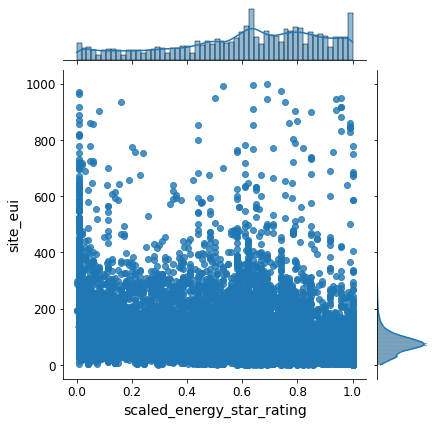

In [381]:
sns.jointplot(x='scaled_energy_star_rating', y='site_eui', data=df_train, kind='reg')

In [398]:
all_features_training = df_train.columns.to_list()[1:]
df_train.columns

Index(['site_eui', 'is_residential', 'year_built_cat', 'scaled_year_built',
       'scaled_energy_star_rating', 'elevation_cat', 'scaled_elevation',
       'scaled_floor_area', 'enc_state_id_0', 'enc_state_id_1',
       ...
       'scaled_winter_max_temp', 'scaled_spring_avg_temp',
       'scaled_spring_min_temp', 'scaled_spring_max_temp',
       'scaled_summer_avg_temp', 'scaled_summer_min_temp',
       'scaled_summer_max_temp', 'scaled_fall_avg_temp',
       'scaled_fall_min_temp', 'scaled_fall_max_temp'],
      dtype='object', length=163)

In [383]:
X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0:1].values

print(X_train.shape,y_train.shape)

(74483, 162) (74483, 1)


#### Training

In [232]:
xgb_reg = xgboost.XGBRegressor(n_estimators=300, tree_method="hist", nthread=-1)
xgb_scores = cross_val_score(xgb_reg,X_train,y_train.ravel(),cv=5,scoring='neg_mean_squared_error')

print(np.sqrt(-xgb_scores))
print("RMSE: {:.3f} +/- {:.3f}".format(np.sqrt(-xgb_scores).mean(), np.sqrt(-xgb_scores).std()))

[48.20344063 43.72055428 44.56807151 39.45014255 38.43665044]
RMSE: 42.876 +/- 3.561


#### Hyperparameter tuning

In [243]:
param_grid = [
    {'n_estimators': [100,200,500], 
     #'max_depth':    [2], 
     'learning_rate':[0.05, 0.1],
     'subsample':    [0.1, 0.5, 1.0], # subsample ratio of the training sample
     'gamma':        [0.], # minimum loss reduction required to grow a tree , not independent on n_estimators
     'reg_alpha':    [0.],
     'reg_lambda':   [1.],
    },
  ]

xgb_reg = xgboost.XGBRegressor(tree_method="hist")

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
             

In [259]:
cvres = grid_search.cv_results_
df_cvres = pd.DataFrame(grid_search.cv_results_)
df_cvres.columns
df_cvres['mean_train_score_rmse'] = np.sqrt(-df_cvres['mean_train_score'])
df_cvres['mean_test_score_rmse'] = np.sqrt(-df_cvres['mean_test_score'])

df_cvres = df_cvres[["mean_train_score_rmse", "mean_test_score_rmse", "params"]]
df_cvres.insert(2,column='diff_train_test_perc', 
                value=(df_cvres['mean_train_score_rmse']/df_cvres['mean_test_score_rmse'] - 1)*100 )
df_cvres.sort_values('diff_train_test_perc').head(10)



,mean_train_score_rmse,mean_test_score_rmse,diff_train_test_perc,params
17,28.795420,43.221913,-33.377730,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}"
16,28.830347,41.377256,-30.323204,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.5}"
15,36.387838,49.521626,-26.521317,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.1}"
8,33.233454,43.472949,-23.553715,"{'gamma': 0.0, 'learning_rate': 0.05, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}"
14,33.795042,43.655908,-22.587701,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}"
7,32.579003,41.711452,-21.894344,"{'gamma': 0.0, 'learning_rate': 0.05, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.5}"
13,33.892677,41.725038,-18.771368,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.5}"
11,36.541737,44.812594,-18.456546,"{'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}"
5,36.646938,44.817959,-18.231578,"{'gamma': 0.0, 'learning_rate': 0.05, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}"
6,37.831386,45.478613,-16.814995,"{'gamma': 0.0, 'learning_rate': 0.05, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.1}"


#### Chosen model

In [386]:
xgb_reg_optim = xgboost.XGBRegressor(tree_method="hist", 
                                     gamma = 0.0, 
                                     learning_rate=0.05, 
                                     n_estimators=500, 
                                     reg_alpha=0.0, 
                                     reg_lambda=1.0, 
                                     subsample=0.5)

xgb_reg_optim.fit(X_train,y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.5,
             tree_method='hist', validate_parameters=1, verbosity=None)

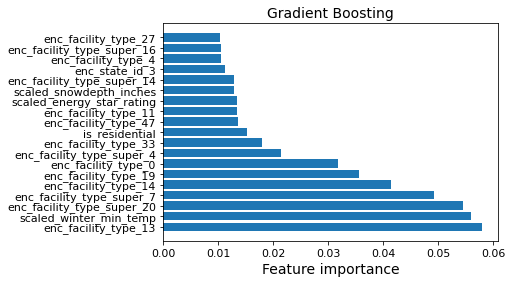

In [409]:
imps_xgb = xgb_reg_optim.feature_importances_
plot_feature_importances(imps_xgb, all_features_training, "Gradient Boosting", 0.01)

#### Predictions on the test set

In [387]:
df_test_nohistory = df_test[df_test['has_previous_history'] == 0].copy()
df_test_nohistory = df_test_nohistory.drop(columns=['has_previous_history','year_factor'])

X_test = df_test_nohistory.iloc[:,1:].values
X_test.shape

(657, 162)

In [388]:
xgb_reg_optim = grid_search.best_estimator_
y_predict_test_nohistory = xgb_reg_optim.predict(X_test)
y_predict_test_nohistory.shape

(657,)

In [389]:
#y_predict_test_nohistory

# Submission

### Get the id

In [390]:
df_pre_train,df_pre_test = splitTestTrain(df_preprocessed)
df_pre_test.shape

(9705, 79)

In [391]:
df_pre_test_history = df_pre_test.loc[df_pre_test['has_previous_history']==1]
df_pre_test_nohistory = df_pre_test.loc[df_pre_test['has_previous_history']==0]

test_id_history = df_pre_test_history['id'].copy()
test_id_nohistory = df_pre_test_nohistory['id'].copy()

test_id_history.shape,test_id_nohistory.shape

((9048,), (657,))

In [392]:
test_id = np.concatenate((test_id_history,test_id_nohistory), axis=0)
test_y_predict = np.concatenate((y_predict_test_history,y_predict_test_nohistory), axis=0)

test_id.shape,test_y_predict.shape

((9705,), (9705,))

In [393]:
df_test_predict = pd.DataFrame(data={'id':test_id,'site_eui':test_y_predict}).sort_values('id')
df_test_predict.to_csv('solution_v01.csv', index=False)